In [1]:
## Download option 1
!pip install gdown

import gdown

#url = 'https://drive.google.com/file/d/1377GxX9ZupjbUgYTjTEzzqPFsapAHNg_/view?usp=sharing'
gdown.download(id="1377GxX9ZupjbUgYTjTEzzqPFsapAHNg_",output="major.zip", quiet=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'major.zip'

In [2]:
# Download option 2
#! wget --header="Host: doc-0g-bg-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US;q=0.9" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_tsdr7d1aub9aq79n3b8o09k5s9h52g4f=00264959805100472870|1659968550000|nopik7n6vm4drpvnd9absfr6cv64emak" --header="Connection: keep-alive" "https://doc-0g-bg-docs.googleusercontent.com/docs/securesc/4ogmqd10ibf5tcostvq13oaf3o3i1l6n/tvckv4jtpf75ma0m3gr1bev72vmq91ki/1659968700000/07966168235963805458/00264959805100472870/1m-MczPwDlbz3Vy7Z0AiCTL0Ugo12d-82?ax=AI9vYm7H7Q5YyX1nEOV19pUBkJFlFX3q50y8wrgz_mJbsf4dJ96DSjuf9SY0tIK-t7PJ8fEws0M6f_K9TfVxLlkgTfzzfu32ieJrwkM2gfUx53Hm-6M6A88lejy4VVQT9amqye2veYoyFQUysU1-Qf9yWLNwIhdjGhVAkzlLGBIUim6XPywEL1EwKniPNQ2enLKLnLvab0QThUiFSJnP-NqmJCmGQ6xJKAE7aiUW2J5eljhcenEQ6ps8IPryH-qq4Z-q0ToK0HpUwrpwfCibCTt_CVH6lrITMfZ89R0FyfVEbX-zG8NWQgtQTK-xdSNH6G_39rb2a9BAp2z6JNIEJyfZmri-0TqzMEiHpYH4UGDeW5KZ4hVkUdIlgQna-TqOQlvW1kYxhf-zbH9cGv51IBWsFYxXzYBrBWqKwTYFUIcLYAVvZGKDHT_LBCIi60A6NqcRiPy9Rc379cNWbuDmCLjoYHyb3Rl2oxPJYZS9qSHkIqym2eY24eSOw9cT2-AwOwo8nzZw10hoXE5AnKPGj4YVL4NF6NwT6Wmr20fDAMyD01OlNOUXQu_EAzGMWozBy4YxBAhEH2DikqgRNXjyVc4nOAIZJ-CTIi9vppqXsPXhW4dR5vwPcDxBs2KwgNH-jMSWphr8dyzGh2O71u1_dAyaFZ_Ltss0jUcf_Wb7D8XRcUsuk_-qqJC4ZZSaVM3HFKH3XSLSk0BnLV79-gw4PDuQfHiu9VbRfIoRu2CEXf02eTYAxcwpcTyEdY0YWcD4OEBGhY_yDlikM9T_zsQTwpAWeCpy9S0Ttv6Dg3PWA0qX7cY2GEh1qh4&uuid=6dda5ba7-3268-490c-b22c-c2afb4851e61&authuser=0" -c -O 'minor.zip'

In [3]:
!unzip -qq major.zip

In [4]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt 
from tqdm import tqdm

import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import RandomCrop

In [5]:
with open("Major/train.txt","r+") as f0:
  train_list = f0.read().split("\n")

with open("Major/val.txt","r+") as f0:
  val_list = f0.read().split("\n")

with open("Major/test.txt","r+") as f0:
  test_list = f0.read().split("\n")

labels = pd.read_csv("Major/labels.csv")

In [6]:
labels["dataset_identifier"].value_counts()

coco_standard             9170
realffhq                  3409
gated inpainting          2000
Taming class              1494
glide text2img            1000
glide inpainting          1000
Taming coco               1000
Taming ffhq               1000
stylegan2 car              400
stylegan2 ffhq             400
stylegan2 horse            400
stylegan2 church           400
stylegan2 cat              400
stylegan3 ffhq-r           200
stylegan3 afhq-r           200
stylegan3 ffhqu-t          200
stylegan3 meltfaces-t      200
stylegan3 ffhq-t           200
stylegan3 afhq-t           200
stylegan3 meltfaces-r      200
stylegan3 ffhqu-r          200
stylegan3 meltfacesu-t     200
stylegan3 meltfacesu-r     200
Name: dataset_identifier, dtype: int64

In [21]:
def construct_dataloder(dataset, batch_size, shuffle=True, num_workers=4):
    return DataLoader(dataset, batch_size=batch_size,
                      shuffle=shuffle, num_workers=num_workers)

class VIPDataset(Dataset):
    def __init__(self, file_ids, labels, data_dir,):
        self.file_ids = file_ids
        self.labels = labels
        self.data_dir = data_dir
        self.distortion_pipeline = A.Compose([A.CLAHE(p=0.2),
                      A.RandomRotate90(p=0.2),
                      A.Transpose(p=0.2),
                      A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.2),
                      A.Blur(blur_limit=3,p=0.2),
                      A.OpticalDistortion(p=0.2),
                      A.GridDistortion(p=0.2),
                      A.HueSaturationValue(p=0.2)])
        
        self.aug = A.Compose([
            A.augmentations.geometric.resize.RandomScale(scale_limit=[0,2],interpolation=cv.INTER_CUBIC,p=0.3),
            A.augmentations.crops.transforms.RandomResizedCrop(200,200,scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=cv.INTER_CUBIC,p=0.5),
        ])
        self.end_transform = A.Compose([A.augmentations.geometric.resize.Resize (200, 200, interpolation=cv.INTER_CUBIC, p=1),A.augmentations.transforms.ImageCompression(quality_lower=65, quality_upper=100, always_apply=False, p=0.4), ToTensorV2()])

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, index):
        image_id = self.file_ids[index]
        img = Image.open(os.path.join(self.data_dir, image_id))
        target = self.labels.loc[self.labels["image_ids"] == image_id].to_dict(orient="records")[0]

        x = np.array(img)
        x = self.distortion_pipeline(image=x)['image']

        if target["dataset_identifier"] not in ["glide inpainting","gated inpainting "]:
          x = self.aug(image=x)['image']
        
        #print(x.shape)
        x = self.end_transform(image=x)['image']


        y = int(target["label"])
        return x, torch.from_numpy(np.array(y))

    def __random_crop(self,img,size,cropsize_min = 160,cropsize_max = 2048,cropsize_ratio = (5,8)):
        height = size[1]
        width = size[0]

        # select the size of crop
        cropmax = min(min(width, height), cropsize_max)
        assert cropmax>=cropsize_min
        
        cropmin = max(cropmax*cropsize_ratio[0]//cropsize_ratio[1], cropsize_min)
        cropsize = random.randint(cropmin, cropmax)
        
        # select the position of the crop
        x1 = random.randint(0, width - cropsize)
        y1 = random.randint(0, height - cropsize)
        
        # make cropping
        img = img[x1:x1+cropsize, y1:y1+cropsize]
        return img

In [22]:
train_ds = VIPDataset(train_list,labels,"Major/data")
val_ds = VIPDataset(val_list,labels,"Major/data")
test_ds = VIPDataset(test_list,labels,"Major/data")

In [23]:
train_dl = construct_dataloder(train_ds, 8, shuffle=True, num_workers=4)
val_dl = construct_dataloder(val_ds, 8, shuffle=True, num_workers=4)
test_dl = construct_dataloder(test_ds, 8, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


5897 torch.Size([3, 200, 200]) torch.Size([])
tensor(1)
12010 torch.Size([3, 200, 200]) torch.Size([])
tensor(0)
1912 torch.Size([3, 200, 200]) torch.Size([])
tensor(1)
4750 torch.Size([3, 200, 200]) torch.Size([])
tensor(0)


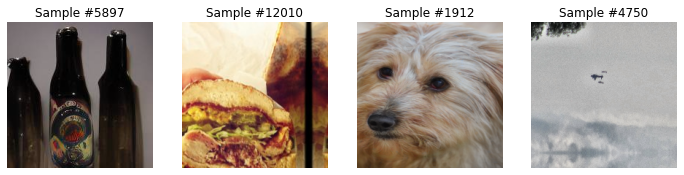

In [24]:
plt.figure(figsize=(12,4))
for j, i in enumerate(random.sample(set(range(len(train_ds))), 4)):
    sample_image, sample_label = train_ds[i]
    print(i, sample_image.shape, sample_label.shape)

    ax = plt.subplot(1, 4, j + 1)
#     plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(np.transpose(sample_image, (1, 2, 0)))
    print(sample_label)
    if i == 3:
        plt.show()
        break

In [11]:
for x, y in train_dl:
  pass

In [12]:
for x, y in tqdm(val_dl):
  pass

100%|██████████| 452/452 [01:33<00:00,  4.85it/s]
